In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

df = pd.read_csv('insurance_claims.csv')
print(df.shape)
#print(df.head(10))

(1000, 39)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [8, 8]

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

df.replace("?", np.nan, inplace=True)
#print(df.describe())


In [4]:
#Data Pre-processing

df.isna().sum()
df['collision_type'] = df['collision_type'].fillna(df['collision_type'].mode()[0])
df['property_damage'] = df['property_damage'].fillna(df['property_damage'].mode()[0])
df['police_report_available'] = df['police_report_available'].fillna(df['police_report_available'].mode()[0])
#print(df.head(10))

#Dropping columns with no predictive power

drop = ['policy_number','policy_bind_date','policy_state','insured_zip','incident_location','incident_date',
           'incident_state','incident_city','insured_hobbies','auto_make','auto_model','auto_year']
df.drop(drop, inplace= True, axis= 1)

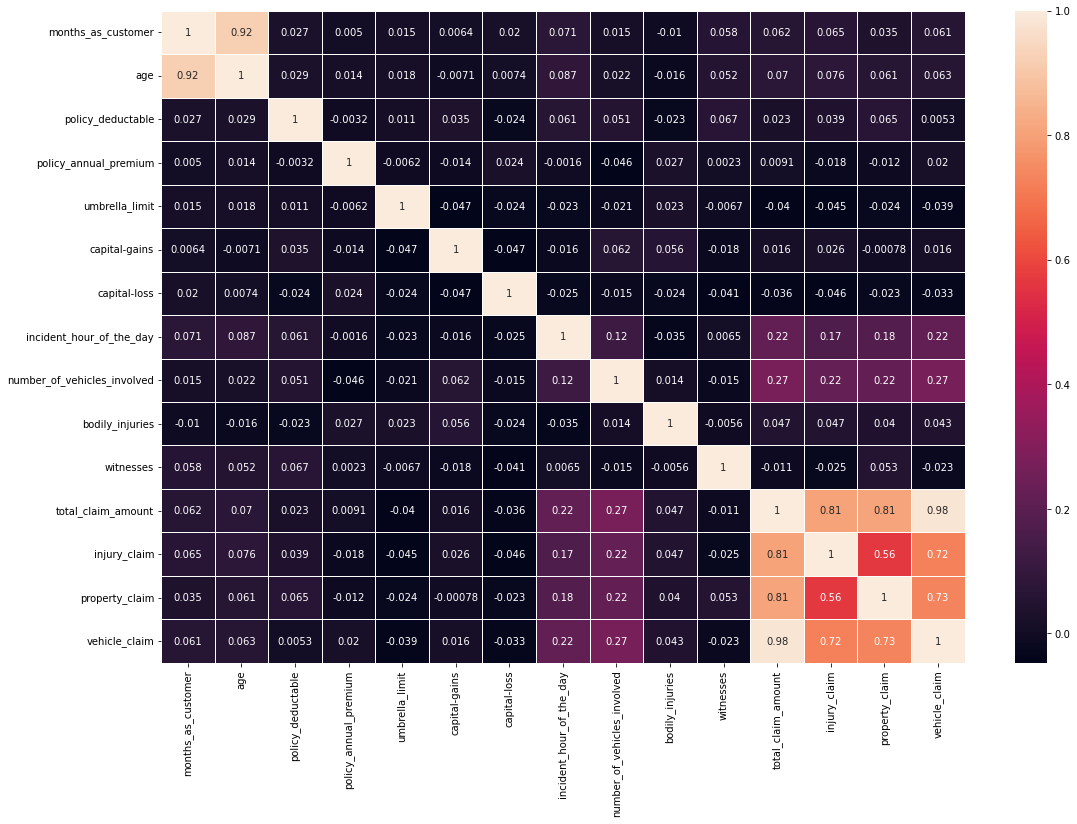

In [5]:
#Correlation Heatmap

corr = df.corr()
plt.figure(figsize = (18,12))
sns.heatmap(data= corr, annot= True, fmt= '.2g', linewidths= 1)
plt.show()

1. age and months_as_customer are 92% correlated, can drop one
2. total_claim_amount is highly correlated with injury_claim, property_claim, and vehicle_claim. Can drop total_claim_amount, as it is largely explained by these 3 columns more concisely

In [6]:
df.drop(columns = ["age", "total_claim_amount"], inplace= True, axis=1)

#separate features and target
features = df.drop('fraud_reported', axis= 1)
target = df['fraud_reported'].replace(to_replace= ['Y', 'N'], value= (1,0))

#Categorical data

cat_df = features.select_dtypes(include= ['object'])
#print(cat_df.head())
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

cat_df = pd.get_dummies(cat_df, drop_first=True)
#print(cat_df.head())

policy_csl: 
['250/500' '100/300' '500/1000']

insured_sex: 
['MALE' 'FEMALE']

insured_education_level: 
['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']

insured_occupation: 
['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']

insured_relationship: 
['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']

incident_type: 
['Single Vehicle Collision' 'Vehicle Theft' 'Multi-vehicle Collision'
 'Parked Car']

collision_type: 
['Side Collision' 'Rear Collision' 'Front Collision']

incident_severity: 
['Major Damage' 'Minor Damage' 'Total Loss' 'Trivial Damage']

authorities_contacted: 
['Police' 'None' 'Fire' 'Other' 'Ambulance']

property_damage: 
['YES' 'NO']

police_report_available: 
['YES' 'NO']



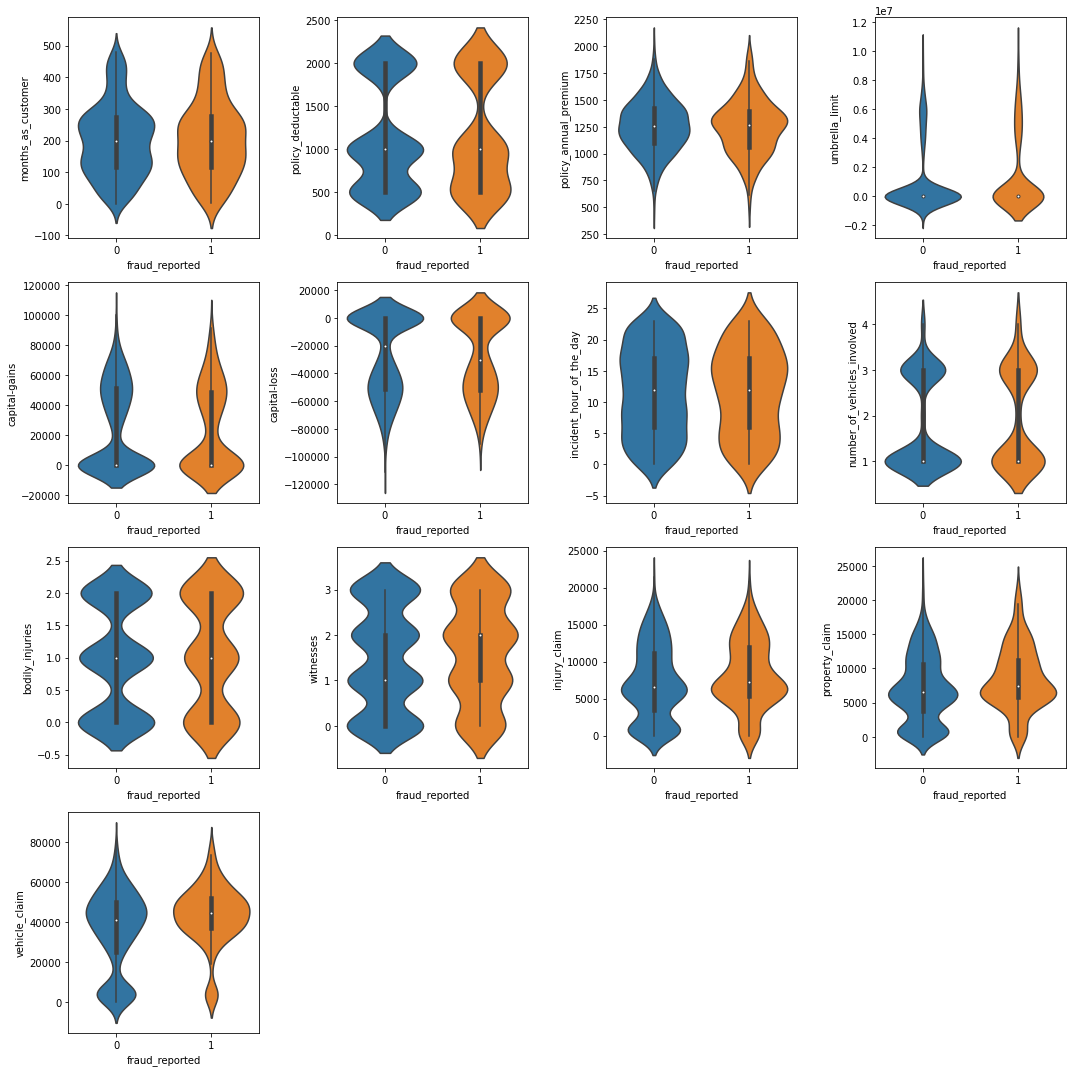

months_as_customer: 
                count        mean         std  min    25%    50%    75%    max
fraud_reported                                                                
0               753.0  202.600266  113.574565  0.0  115.0  200.0  276.0  479.0
1               247.0  208.080972  119.824064  3.0  116.0  199.0  279.0  478.0

policy_deductable: 
                count         mean         std    min    25%     50%     75%     max
fraud_reported                                                                      
0               753.0  1130.810093  606.771634  500.0  500.0  1000.0  2000.0  2000.0
1               247.0  1151.821862  628.123674  500.0  500.0  1000.0  2000.0  2000.0

policy_annual_premium: 
                count         mean         std     min       25%      50%      75%      max
fraud_reported                                                                             
0               753.0  1258.430000  241.247210  433.33  1097.640  1253.12  1422.56  2047.59
1

In [7]:
#Numerical data

num_df = features.select_dtypes(include= ['float64', 'int64'])
#print(num_df.head())


cols = num_df.columns
size = len(num_df.columns)
#print(size)
x = target
y = cols[0:size]

plt.figure(figsize= (15, 15))
for i in range(0, size):
    plt.subplot(4, 4, i+1)
    sns.violinplot(data= num_df, x= x, y= y[i])
plt.tight_layout()    
plt.show()   

#print(df.groupby(['fraud_reported']).describe())
num_target_df = pd.concat([num_df, target], axis= 1)
for col in num_target_df.columns:
    #print(col)
    print(f"{col}: \n{num_target_df[col].groupby([num_target_df['fraud_reported']]).describe()}\n")


In [8]:
#Training set and Test set

final_df = pd.concat([cat_df, num_df], axis=1)
#print(final_df.head())

from sklearn.model_selection import train_test_split

feature_train, feature_test, target_train, target_test = train_test_split(final_df, target, test_size= 0.25)

num_df = feature_train[['months_as_customer', 'policy_deductable', 'umbrella_limit',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'injury_claim', 'property_claim',
       'vehicle_claim']]

#Scaling numeric values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_df)

scaled_num_df = pd.DataFrame(data= scaled_data, columns= num_df.columns, index= feature_train.index)
#scaled_num_df.head(10)

feature_train.drop(columns= scaled_num_df.columns, inplace= True)
feature_train = pd.concat([scaled_num_df, feature_train], axis= 1)
feature_train.head()


#Here be dragons

size = 13 #Categorical data begins in 13th column
cols = final_df.columns
x_all = []
x_all.append(['Orig', 'All', feature_train, feature_test, 1.0, cols])

x_temp = StandardScaler().fit_transform(feature_train.iloc[:,0:size])
x_val_temp = StandardScaler().fit_transform(feature_test.iloc[:,0:size])

x_con = np.concatenate((x_temp, feature_train.iloc[:,size:]), axis= 1)
x_val_con = np.concatenate((x_val_temp, feature_test.iloc[:,size:]), axis= 1)

x_all.append(['StdSca', 'All', x_con, x_val_con, 1.0, cols])
#print(x_all)

In [9]:
#Model building

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

models = []
models.append(('Logit', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))

LogitOrig: 0.794667 (0.403945)
[[150  39]
 [ 46  15]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       189
           1       0.28      0.25      0.26        61

    accuracy                           0.66       250
   macro avg       0.52      0.52      0.52       250
weighted avg       0.65      0.66      0.65       250

LDAOrig: 0.805333 (0.395944)
[[108  81]
 [ 36  25]]
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       189
           1       0.24      0.41      0.30        61

    accuracy                           0.53       250
   macro avg       0.49      0.49      0.47       250
weighted avg       0.62      0.53      0.56       250

KNNOrig: 0.701333 (0.457673)
[[189   0]
 [ 61   0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       189
           1       0.00      0.00      0.00        61

    accuracy            

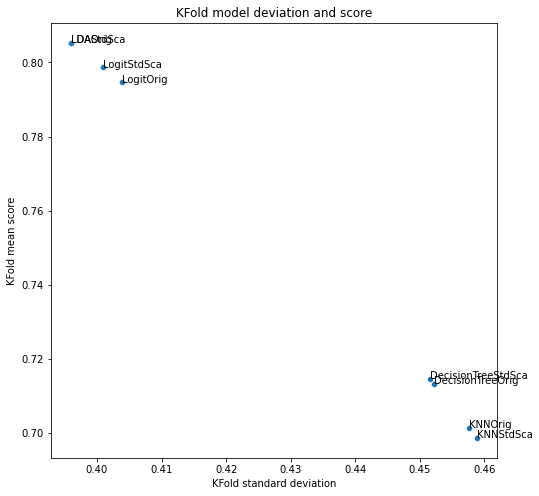

In [10]:
#Model eval

results, names = [], []
scoring = 'accuracy'

for trans, name, x, x_val, v, cols_list in x_all:
    for modName, model in models:
        kfold = model_selection.KFold(n_splits= 750)
        #print(kfold)
        cv_results = model_selection.cross_val_score(model, x, target_train, cv= kfold, scoring= scoring)
        #print(cv_results)
        results.append((modName+trans, cv_results))
        names.append(modName+trans)
        msg = '%s: %f (%f)' % (modName+trans, cv_results.mean(), cv_results.std())
        print(msg)
        
        model.fit(feature_train, target_train)
        target_pred = model.predict(feature_test)
        print(confusion_matrix(target_test, target_pred))
        print(classification_report(target_test, target_pred))
        #print('\n')

#print(results)
means, stds, model_names = [], [], []
for tuple in results:
    #print(tuple)
    means.append(tuple[1].mean())
    stds.append(tuple[1].std())
    model_names.append(tuple[0])

fig, ax = plt.subplots()
sns.scatterplot(x= stds, y= means)
plt.title("KFold model deviation and score")
plt.ylabel("KFold mean score")
plt.xlabel("KFold standard deviation")
for i, txt in enumerate(model_names):
    ax.annotate(txt, (stds[i], means[i]))